In [2]:
### This script compare the grofiler result between the cell specific gene and common architecture genes
### Author:Yiyun

import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
import seaborn as sns

In [4]:
import matplotlib
# settings
plt.interactive(False)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
def set_snsfont(s):
    sns.set(font_scale=s)
    sns.set_style("white")
set_snsfont(1.5)

***Top 100 GO terms p-value compare***

In [3]:
### READ go results
df_target = pd.read_csv('target_gores.csv')
df_predictor = pd.read_csv('predictor_gores.csv')

In [5]:
### Construct dataframe of target/predictor common top100 p-values
# 1. Get top100 p-val and terms
n = 100
df_target_top = df_target.sort_values('p_value').head(n)
df_predictor_top = df_predictor.sort_values('p_value').head(n)

# 2. Term intersection - find common terms in top100 lists
# between target and predictor only
common_termname_target_pre = list(set(df_target_top['term_name']).intersection(df_predictor_top['term_name']))

# 3. get data according to common termnames 
df_target_top_common = df_target_top[df_target_top['term_name']\
            .isin(common_termname_target_pre)][['term_id','term_name','p_value','intersection_size']]\
            .set_index('term_id').add_suffix('_target')
df_predictor_top_common = df_predictor_top[df_predictor_top['term_name']\
            .isin(common_termname_target_pre)][['term_id','term_name','p_value','intersection_size']]\
            .set_index('term_id').add_suffix('_predictor')

# 4. combine dataframe of target and predictor only-- log10 p-vals of common terms
df_combine = pd.concat([df_target_top_common,df_predictor_top_common],axis = 1)

# 5. Log10 transformation
df_combine['p_value_target'] = -np.log10(df_combine['p_value_target'])
df_combine['p_value_predictor'] = -np.log10(df_combine['p_value_predictor'])

/Users/stella/miniconda3/envs/cnp/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The set_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  


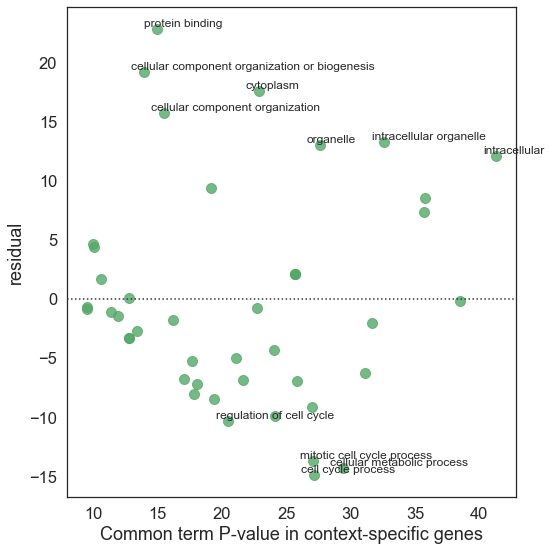

In [21]:
### residual plot
plt.figure(figsize=(8,8))
ax = sns.residplot(x='p_value_target', y='p_value_predictor', data =df_combine, color="g",scatter_kws={"s": 100})
ax.set_ylabel('residual');ax.set_xlabel('Common term P-value in context-specific genes')

# Annotate terms that higher than 10 threshold
# ----------------------
# Code referenced from
# https://stackoverflow.com/questions/32213889/get-positions-of-points-in-pathcollection-created-by-scatter
# ----------------------
text = df_combine['term_name_target'] # terms for annotation
# get positions
offset = ax.collections[0]
offset.set_offset_position('data')
datapos = offset.get_offsets()

# for dot and their positions, if pass the threshold, then annotate
for i in range(len(datapos)):
    xval = datapos[i][0];yval = datapos[i][1]
    if yval > 10 or yval < -10:
        # Find the term corresponding to the position
        termname = df_combine[df_combine['p_value_target'] == xval]['term_name_target'].values[0]
        ax.annotate(termname, (xval-1,yval +0.2), fontsize=12)

plt.tight_layout()
plt.show()
# plt.savefig("%s/fig3_residual.png" % dir_out)

***Test for dummy values***

In [27]:
### Assign dummy value to not shared terms
# 1. Find the union of terms
union_termname_target_pre = list(set(df_target_top['term_name'].tolist()+df_predictor_top['term_name'].tolist()))

# 2. Find the lowest p-val in each list 
predictor_min = max(df_predictor_top['p_value'])
target_min = max(df_target_top['p_value'])

# 3. Identify terms to assign  values(different from specific because thiese include the union)
target_termname = df_target_top['term_name'].tolist()
predictor_termname = df_predictor_top['term_name'].tolist()
target_toadd = [i for i in union_termname_target_pre if i not in target_termname]
predictor_toadd = [i for i in union_termname_target_pre if i not in predictor_termname]

# 4. Generate dataframes that contain dummy values, using the least significant p-values
df_target_dummy = pd.DataFrame(columns = ['p_value','term_name'])
df_target_dummy['term_name'] = target_toadd
df_target_dummy['p_value'] = target_min
df_predictor_dummy = pd.DataFrame(columns = ['p_value','term_name'])
df_predictor_dummy['term_name'] = predictor_toadd
df_predictor_dummy['p_value'] = predictor_min

# 5. the dummy value dataframe
df_target_combine = pd.concat([df_target_top[['p_value','term_name']], df_target_dummy],axis = 0)
df_predictor_combine = pd.concat([df_predictor_top[['p_value','term_name']], df_predictor_dummy],axis = 0)
df_target_combine = df_target_combine.set_index('term_name').add_suffix('_target')
df_predictor_combine = df_predictor_combine.set_index('term_name').add_suffix('_predictor')

# 5. Combine target and predictor dataframes
df_combine_dummy = pd.concat([df_target_combine,df_predictor_combine],axis = 1)

# 6. Log10 transformation
df_combine_dummy['p_value_target'] = -np.log10(df_combine_dummy['p_value_target'])
df_combine_dummy['p_value_predictor'] = -np.log10(df_combine_dummy['p_value_predictor'])

/Users/stella/miniconda3/envs/cnp/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The set_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  


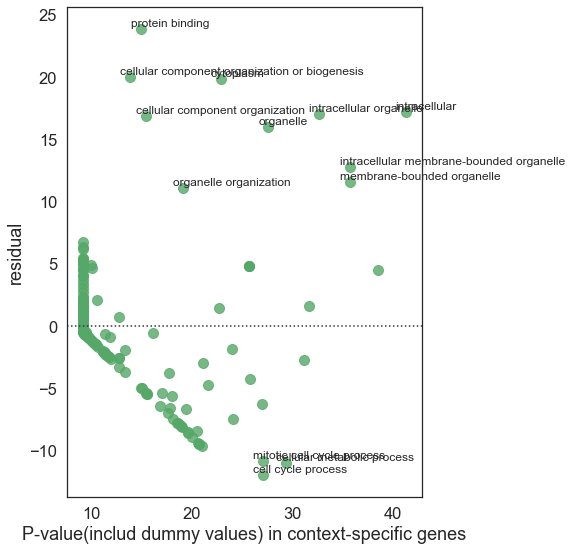

In [28]:
### Residual plot
plt.figure(figsize=(8,8))
ax = sns.residplot(x='p_value_target', y='p_value_predictor', data =df_combine_dummy, color="g",scatter_kws={"s": 100})
ax.set_ylabel('residual');ax.set_xlabel('P-value(include dummy values) in context-specific genes')

# Annotate terms that higher than 10 threshold
# ----------------------
# Code referenced from
# https://stackoverflow.com/questions/32213889/get-positions-of-points-in-pathcollection-created-by-scatter
# ----------------------
text = df_combine_dummy.index.tolist() # terms for annotation
# get positions
offset = ax.collections[0]
offset.set_offset_position('data')
datapos = offset.get_offsets()

# for dot and their positions, if pass the threshold, then annotate
for i in range(len(datapos)):
    xval = datapos[i][0];yval = datapos[i][1]
    if yval > 10 or yval < -10:
        # Find the term corresponding to the position
        termname = df_combine_dummy[df_combine_dummy['p_value_target'] == xval].index.values[0]
        ax.annotate(termname, (xval-1,yval +0.2), fontsize=12)

plt.tight_layout()
plt.show()
# plt.savefig("%s/fig3_residual.png" % dir_out)